In [7]:
%matplotlib inline
from object_detection.utils import visualization_utils as viz_utils
import matplotlib.pyplot as plt

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

testing TKAgg
testing GTKAgg
testing Qt4Agg
testing WXAgg
Using: module://ipykernel.pylab.backend_inline


In [11]:
import tensorflow as tf
import numpy as np
num_epochs = 1
IM_H, IM_W = 640, 640 #384,512
NUM_CLASSES = 2

def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)




def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32) * 255.
  img = tf.image.resize(img, [IM_H,IM_W])
  #img = tf.image.random_flip_left_right(img)
  #img = tf.image.random_flip_up_down(img)
  #img = tf.image.random_brightness(img, 0.3)
  return img

def get_label(path):
  part_list = tf.strings.split(path, "/")
  # in the case where each class of images is in one folder
  return part_list[-2] == class_names

def process_path(file_path):
  label = get_label(file_path)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label


def resss(parsed):
    image = decode_img(parsed['image'])
    #boxes = tf.stack([parsed[k] for k in ['xmin', 'xmax', 'ymin', 'ymax']], axis = 1)
    box = tf.stack([tf.sparse.to_dense(parsed[k]) for k in ['ymin', 'xmin', 'ymax', 'xmax']], axis = 1)
    label = tf.cast(tf.sparse.to_dense(parsed['label']), tf.int32)
    label = tf.one_hot(label, NUM_CLASSES)
    return image , box, label

feature_description = {
        'image': tf.io.FixedLenFeature((), tf.string, default_value=''),
        'xmin':
            tf.io.VarLenFeature(tf.float32),
        'xmax':
            tf.io.VarLenFeature(tf.float32),
        'ymin':
            tf.io.VarLenFeature(tf.float32),
        'ymax':
            tf.io.VarLenFeature(tf.float32),
        'label':
            tf.io.VarLenFeature(tf.int64),
}

def get_iter_dataset(tfr_path, repeats = 1):
    ds = tf.data.TFRecordDataset([tfr_path])
    ds = ds.cache()
    ds = ds.map(_parse_function)
    ds = ds.map(resss)
    ds = ds.shuffle(10)
    ds = ds.repeat(repeats)
    return iter(train_ds)


train_ds = get_iter_dataset("/tmp/train_data.tfr")


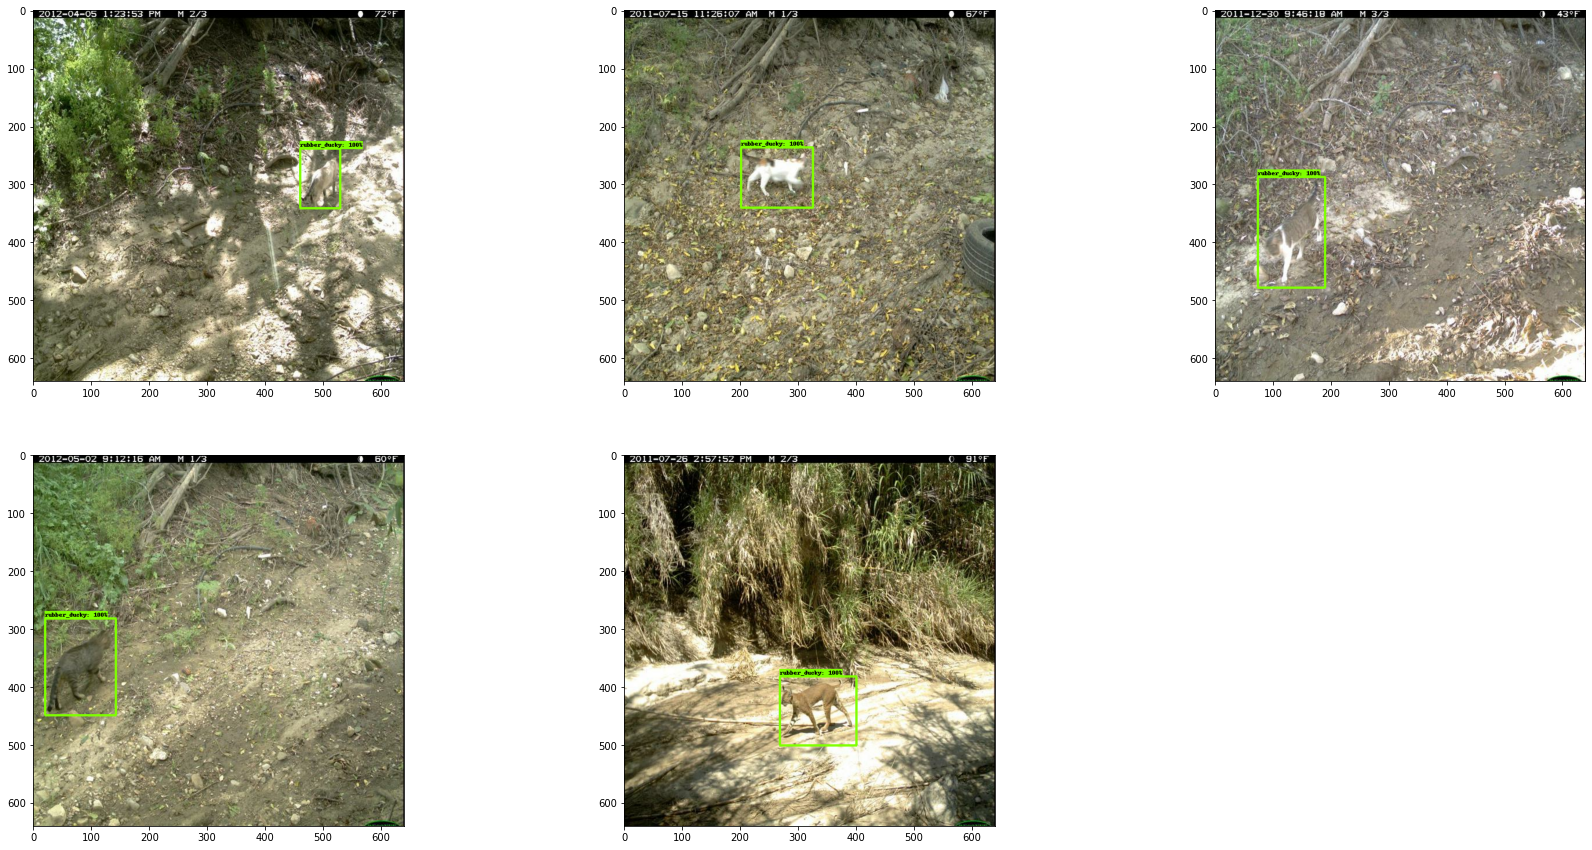

In [12]:
%matplotlib inline

examples = [next(train_ds) for _ in range(10)]
train_images_np = [example[0].numpy().astype(np.uint8) for example in examples]
gt_boxes = [example[1].numpy() for example in examples]
#labels = [example[2].numpy() for example in examples]
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%
category_index = {1: {'id': 1, 'name': 'rubber_ducky'}}



plt.figure(figsize=(30, 15))
for idx in range(5):
    plt.subplot(2, 3, idx+1)
    plot_detections(
        train_images_np[idx],
        gt_boxes[idx],
        np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
        dummy_scores, category_index)
plt.show()

In [10]:
##Test the model

In [17]:
@tf.function
def detect(input_tensor):
    """Run detection on an input image.

    Args:
      input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
        Note that height and width can be anything since the image will be
        immediately resized according to the needs of the model within this
        function.

    Returns:
      A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
        and `detection_scores`).
    """
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)
    return detection_model.postprocess(prediction_dict, shapes)

NameError: in user code:

    <ipython-input-17-d3ca3a58a06f>:15 detect  *
        preprocessed_image, shapes = detection_model.preprocess(input_tensor)

    NameError: name 'detection_model' is not defined


In [68]:
from object_detection.core.post_processing import batch_iou

In [45]:
model = tf.saved_model.load(
    "servable/saved_model", tags=None, options=None
)
f = model.signatures["serving_default"]

In [79]:

def predict(serving_fn, image):
    pred = serving_fn(input_tensor = image)
    num_detections = np.squeeze(pred['num_detections'].numpy().astype(np.int32), axis=(0,))
    detection_scores = np.squeeze(pred['detection_scores'].numpy(), axis=(0,))[0:num_detections]
    class_indices =  np.squeeze(pred['detection_classes'].numpy().astype(np.int32), axis=(0,))[0:num_detections]
    #boxes = np.squeeze(pred['detection_boxes'].numpy() * np.array([640,640, 640,640]), axis=(0,))[0:num_detections]
    boxes = np.squeeze(pred['detection_boxes'].numpy(), axis=(0,))[0:num_detections]
    #ymin, xmin, ymax, xmax = np.split(boxes, 4, axis=-1)
    #processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
    min_score = 0.5
    keep_indices = detection_scores > min_score
    #keep_indices = keep_indices & np.isin(response['class_indices'], list(class_mappings.keys()))
    boxes = boxes[keep_indices]
    return boxes

(1, 4)

In [71]:
image = np.expand_dims(example[0].numpy().astype(np.uint8).copy(), axis = 0)
boxes = predict(f, image)

image= tf.image.draw_bounding_boxes(
    image, tf.expand_dims(boxes, axis = 0), [[255,0,0,0]], name=None
)

image= tf.image.draw_bounding_boxes(
    image, tf.expand_dims(example[1].numpy(), axis = 0), [[0,255,0,0]], name=None
)



In [72]:
from PIL import Image

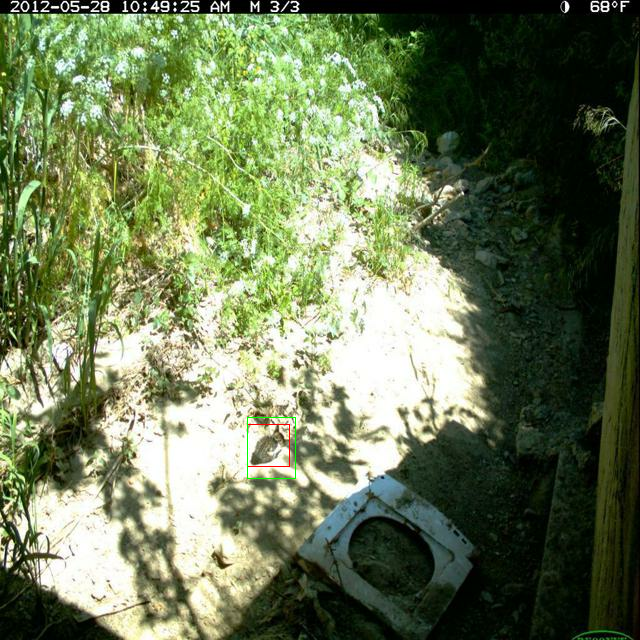

In [74]:
Image.fromarray(np.squeeze(image.numpy().astype(np.uint8)))

In [82]:

test_ds = get_iter_dataset("/tmp/train_data.tfr")

count = 0

ious = []
for example in test_ds:
    image = np.expand_dims(example[0].numpy().astype(np.uint8).copy(), axis = 0)
    boxes = predict(f, image)
    if not len(boxes):
        print("continue")
        continue
    batch_boxes = tf.expand_dims(boxes, axis = 0)
    ious.append(batch_iou(batch_boxes, tf.expand_dims(example[1].numpy(), axis = 0)))
    count += 1
    if count > 20:
        break
    
    

continue
continue
continue
continue
continue
